In [1]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
from Functions import total_function_multiprocessing

list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
#list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
list_minutes = [180, 360, 1440, 1440*3]
list_event_buy_volume = [0.65, 0.75, 0.85]
list_event_volume = [6,8,12,15,20,30,50]
n_processes = 8

LOAD_DATA = False
FREE_LOCK = True

if FREE_LOCK:
    shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA)

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-27-8-2023 does not exist. Making the request to the server..
StatusCode for getting get-benchmarkinfo: 200
total_combinantions :  4116
/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-27-8-2023 exists. Loading the file...
['/Users/albertorainieri/Projects/Personal/analysis/json/data-28-07-2023-22-42.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-06-07-2023-00-01.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-02-07-2023-06-01.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-05-08-2023-12-36.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-21-07-2023-05-56.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-25-07-2023-03-40.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-19-6-2023-10-45.json', '/Users/albertorainieri/Projects/Personal/analysis/json/data-25-08-2023-02-43.json

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 1 has started
Slice 2 has started
Slice 3 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 4 has started
Slice 5 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 6 has started
Slice 7 has started


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Slice 8 has started
1/10 of data analyzed
1/4 of data analyzed
1/2 of data analyzed
3/4 of data analyzed
size of shared_data_value before completion of 2: 1.207242 Mb; Number of events saved: 11634
size of shared_data_value before completion of 5: 1.978888 Mb; Number of events saved: 19959
size of shared_data_value before completion of 8: 3.067228 Mb; Number of events saved: 31406
size of shared_data_value before completion of 3: 4.039949 Mb; Number of events saved: 41798
size of shared_data_value before completion of 6: 5.01447 Mb; Number of events saved: 52562
size of shared_data_value before completion of 4: 6.120723 Mb; Number of events saved: 64843
size of shared_data_value before completion of 1: 7.369268 Mb; Number of events saved: 79404
size of shared_data_value before completion of 7: 8.697904 Mb; Number of events saved: 95015
pool closed
pool joined
analysis_json is loaded with file_path: /Users/albertorainieri/Projects/Personal/analysis/analysis_json/analysis.json
new data w

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
# # INTEGRATION
# from Functions import total_function_multiprocessing
# from time import sleep


# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# #list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_minutes = [180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [15,30,50]
# n_processes = 8

# LOAD_DATA = False
# FREE_LOCK = False

# for i in range(1):
#     print(f'ITERATION {i}')
#     if FREE_LOCK:
#         shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, INTEGRATION=True)
#     sleep(60)
    

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING LESS RAM

# from Functions import total_function_multiprocessing_lessRAM
# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [4,6,8,12,20]
# n_processes = 8

# SLICE_I = 1
# LOAD_DATA = False
# FREE_LOCK = True

# if FREE_LOCK:
#     shared_data = total_function_multiprocessing_lessRAM(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, SLICE_I)

# import os
# duration = 2  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))


In [1]:
# # DOWNLOAD AND SHOW NESTED OUTPUT FROM TOTAL MULTIPROCESSING 
from Functions import nested_download_show_output
import pandas as pd
pd.set_option('display.max_rows', None)

# minimum_event_number_list MUST BE a list IN REVERSE ORDER
minimum_event_number = [25, 15, 10, 5]
minimum_coin_number = 0
mean_threshold = 5
lb_threshold = -15
frequency_threshold = 1
group_coins = False
best_coins_volatility = 5

output, info = nested_download_show_output(minimum_event_number_list=minimum_event_number, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold,
                                       group_coins=group_coins, best_coins_volatility=best_coins_volatility)

df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)

/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Download completed in 3.66 seconds


,mean,std,upper_bound,lower_bound,n_coins,n_events,frequency/month
buy_vol_3h:0.65/vol_3h:12/timeframe:360/vlty:2,21.80,17.15,38.95,4.65,6.0,6.0,3.40
buy_vol_60m:0.65/vol_60m:30/timeframe:360/vlty:2,14.22,12.88,27.10,1.34,11.0,11.0,6.11
buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1,14.14,20.96,35.10,-6.82,10.0,11.0,4.40
buy_vol_60m:0.75/vol_60m:20/timeframe:1440/vlty:3,11.85,11.22,23.07,0.63,7.0,8.0,4.44
buy_vol_15m:0.65/vol_6h:20/timeframe:4320/vlty:1,9.60,16.13,25.73,-6.53,6.0,6.0,2.34
buy_vol_30m:0.65/vol_5m:30/timeframe:4320/vlty:1,8.82,16.50,25.32,-7.68,17.0,20.0,8.00
buy_vol_3h:0.65/vol_60m:20/timeframe:360/vlty:2,8.66,11.22,19.88,-2.56,15.0,16.0,7.74
buy_vol_30m:0.85/vol_30m:20/timeframe:4320/vlty:3,8.00,9.31,17.31,-1.31,9.0,10.0,6.82
buy_vol_15m:0.85/vol_15m:30/timeframe:4320/vlty:3,7.95,9.78,17.73,-1.83,14.0,16.0,7.16
buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4,7.54,13.61,21.15,-6.07,5.0,5.0,2.50


In [ ]:
# # DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
# from Functions import download_show_output
# import pandas as pd
# pd.set_option('display.max_rows', None)

# minimum_event_number = 5
# minimum_coin_number = 8
# mean_threshold = 3
# lb_threshold = -15
# frequency_threshold = 2
# group_coins = False
# best_coins_volatility = 10

# output, info = download_show_output(minimum_event_number=minimum_event_number, minimum_coin_number=minimum_coin_number,
#                                       mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold,
#                                        group_coins=group_coins, best_coins_volatility=best_coins_volatility)
# df = pd.DataFrame(output).transpose()
# df.sort_values(by=['mean'], ascending=False)
# #df.sort_values(by=['lower_bound'], ascending=False)

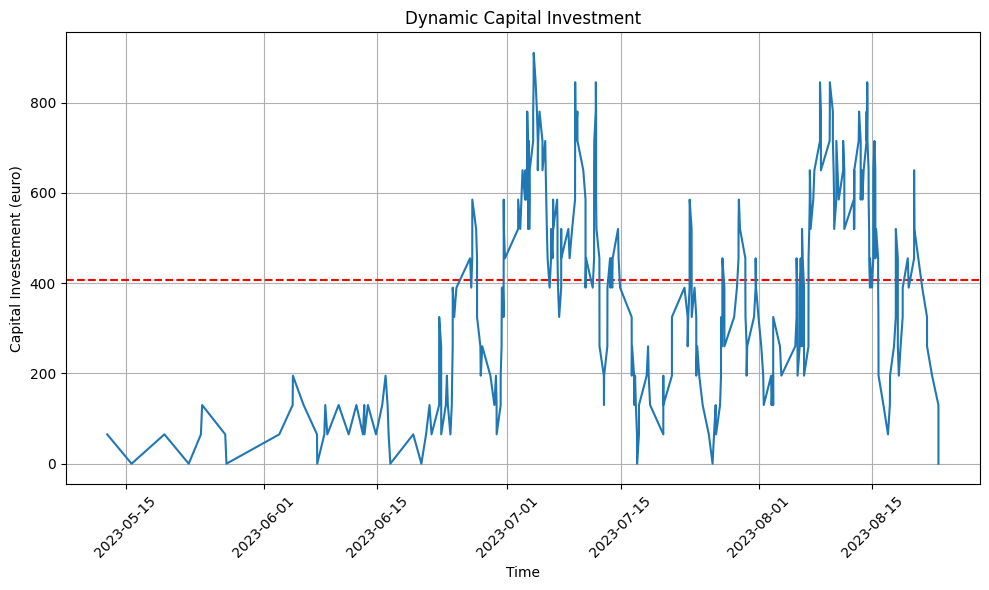

In [2]:
from Functions import check_invevestment_amount
check_invevestment_amount(info, output, investment_amount=65)

In [ ]:
key = 'buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1'

In [ ]:
from Functions import getTimeseries
for key in info:
    response = getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=True)

In [ ]:
# from Functions import getTimeseries

# key = 'buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4'
# getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=True)

In [ ]:
from Functions import infoTimeseries
#key = 'buy_vol_5m:0.65/vol_24h:8/timeframe:4320/vlty:1'
timeseries_info = infoTimeseries(info, key)
timeseries_info


In [ ]:
# ANALYZE RISKMANAGEMENT FOR ONLY 1 KEY
pd.set_option('display.max_colwidth', None)

from Functions import RiskManagement
import pandas as pd
pd.set_option('display.max_rows', None)
#key = 'buy_vol_3h:0.65/vol_6h:6/timeframe:360/vlty:2'
df1, df2, best_risk_key, optimized_riskconfiguration_results = RiskManagement(key, investment_per_event=100)
df1 = df1.sort_values(by=['mean'], ascending=False)
df2 = df2.sort_values(by=['events'], ascending=True)

#result = pd.concat([df1, df2], axis=0)
print(df2)
df1

In [3]:
# ANALYZE THE RISKMANAGEMENT OF ALL KEYS FROM INFO
from Functions import RiskConfiguration
optimized_gain_threshold = 10
mean_gain_threshold = 5

riskmanagement_conf = (minimum_event_number, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility)
df  = RiskConfiguration(info, riskmanagement_conf, optimized_gain_threshold, mean_gain_threshold)
df

14 keys will be analyzed in terms of risk configuration
buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1
ITERATION 1 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

363.76 euro of profit for an investment of 100 euro per event (total of 27 events). risk_golden_zone:0.8_step:0.2_step_no_golden:0.01_extratime:0.0 with 13.47 %
buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2
ITERATION 2 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

278.21 euro of profit for an investment of 100 euro per event (total of 31 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.0 with 8.97 %
buy_vol_60m:0.75/vol_60m:12/timeframe:4320/vlty:3
ITERATION 3 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_60m:0.75/vol_60m:12/timeframe:4320/vlty:3
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

318.11 euro of profit for an investment of 100 euro per event (total of 26 events). risk_golden_zone:0.6_step:0.05_step_no_golden:0.01_extratime:0.0 with 12.23 %
buy_vol_3h:0.65/vol_60m:20/timeframe:360/vlty:2
ITERATION 4 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_3h:0.65/vol_60m:20/timeframe:360/vlty:2
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

247.01 euro of profit for an investment of 100 euro per event (total of 15 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.0 with 16.47 %
buy_vol_30m:0.65/vol_5m:30/timeframe:4320/vlty:1
ITERATION 5 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_30m:0.65/vol_5m:30/timeframe:4320/vlty:1
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

366.13 euro of profit for an investment of 100 euro per event (total of 20 events). risk_golden_zone:0.25_step:0.3_step_no_golden:0.01_extratime:0.0 with 18.31 %
buy_vol_15m:0.85/vol_15m:30/timeframe:4320/vlty:3
ITERATION 6 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_15m:0.85/vol_15m:30/timeframe:4320/vlty:3
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

246.82 euro of profit for an investment of 100 euro per event (total of 16 events). risk_golden_zone:0.7_step:0.05_step_no_golden:0.01_extratime:0.0 with 15.43 %
buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1
ITERATION 7 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

385.18 euro of profit for an investment of 100 euro per event (total of 11 events). risk_golden_zone:0.4_step:0.25_step_no_golden:0.01_extratime:0.0 with 35.02 %
buy_vol_30m:0.85/vol_30m:20/timeframe:4320/vlty:3
ITERATION 8 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_30m:0.85/vol_30m:20/timeframe:4320/vlty:3
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

139.37 euro of profit for an investment of 100 euro per event (total of 10 events). risk_golden_zone:0.8_step:0.05_step_no_golden:0.01_extratime:0.0 with 13.94 %
buy_vol_30m:0.65/vol_3h:50/timeframe:1440/vlty:4
ITERATION 9 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_30m:0.65/vol_3h:50/timeframe:1440/vlty:4
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

71.99 euro of profit for an investment of 100 euro per event (total of 14 events). risk_golden_zone:1_step:0.05_step_no_golden:0.01_extratime:0.0 with 5.14 %
buy_vol_60m:0.65/vol_60m:30/timeframe:360/vlty:2
ITERATION 10 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_60m:0.65/vol_60m:30/timeframe:360/vlty:2
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

250.6 euro of profit for an investment of 100 euro per event (total of 11 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.0 with 22.78 %
buy_vol_15m:0.65/vol_6h:20/timeframe:4320/vlty:1
ITERATION 11 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_15m:0.65/vol_6h:20/timeframe:4320/vlty:1
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

95.22 euro of profit for an investment of 100 euro per event (total of 6 events). risk_golden_zone:0.1_step:0.2_step_no_golden:0.01_extratime:0.0 with 15.87 %
buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4
ITERATION 12 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

79.97 euro of profit for an investment of 100 euro per event (total of 5 events). risk_golden_zone:1_step:0.05_step_no_golden:0.01_extratime:0.0 with 15.99 %
buy_vol_3h:0.65/vol_3h:12/timeframe:360/vlty:2
ITERATION 13 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_3h:0.65/vol_3h:12/timeframe:360/vlty:2
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

223.16 euro of profit for an investment of 100 euro per event (total of 6 events). risk_golden_zone:1_step:0.075_step_no_golden:0.01_extratime:0.0 with 37.19 %
buy_vol_60m:0.75/vol_60m:20/timeframe:1440/vlty:3
ITERATION 14 has started
File exists, Download from local...
Status Code is :  200
All data have been downloaded
0 new events for buy_vol_60m:0.75/vol_60m:20/timeframe:1440/vlty:3
Number of combinations 77


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1

182.68 euro of profit for an investment of 100 euro per event (total of 8 events). risk_golden_zone:0.5_step:0.05_step_no_golden:0.01_extratime:0.0 with 22.84 %
264.7298331260681 seconds spent to run wrap_analyze_events


,keys,golden_zone,step_golden,step_nogolden,extra_timeframe,optimized_gain,optimized_std,frequency,mean_gain,median_gain,std_gain
6,buy_vol_3h:0.65/vol_3h:12/timeframe:360/vlty:2,1,0.075,0.01,0.0,37.19,46.77,3.40,26.76,29.23,27.50
2,buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1,0.4,0.25,0.01,0.0,35.02,73.69,4.40,18.32,20.00,40.04
10,buy_vol_60m:0.75/vol_60m:20/timeframe:1440/vlty:3,0.5,0.05,0.01,0.0,22.84,34.02,4.44,15.92,15.64,25.58
5,buy_vol_60m:0.65/vol_60m:30/timeframe:360/vlty:2,1,0.075,0.01,0.0,22.78,38.48,6.11,17.00,18.44,23.91
1,buy_vol_30m:0.65/vol_5m:30/timeframe:4320/vlty:1,0.25,0.3,0.01,0.0,18.31,53.90,8.00,10.38,11.69,34.23
4,buy_vol_3h:0.65/vol_60m:20/timeframe:360/vlty:2,1,0.075,0.01,0.0,16.47,35.81,7.74,12.23,13.28,24.08
11,buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4,1,0.05,0.01,0.0,15.99,37.12,2.50,9.11,11.06,23.72
3,buy_vol_15m:0.65/vol_6h:20/timeframe:4320/vlty:1,0.1,0.2,0.01,0.0,15.87,40.85,2.34,8.11,9.88,35.80
8,buy_vol_15m:0.85/vol_15m:30/timeframe:4320/vlty:3,0.7,0.05,0.01,0.0,15.43,31.15,7.16,9.76,9.63,22.32
9,buy_vol_30m:0.85/vol_30m:20/timeframe:4320/vlty:3,0.8,0.05,0.01,0.0,13.94,29.22,6.82,9.85,9.57,22.15


In [ ]:
from Functions import load_riskconfiguration
#another_riskconfiguration = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2-8-2023-10-3-717.json"

another_riskconfiguration = None

df = load_riskconfiguration(another_riskconfiguration)
df

In [20]:
from Functions import send_riskconfiguration
response = send_riskconfiguration()

Status Code is :  200


the profit of the entire timeseries is 18.0% with 161 events
the post profit is nan% with 0 events
Positive events: 83
Negative events: 78
Biggest Drop: 56.04 at 2023-07-20T05:59:02.353163


/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/albertorainieri/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


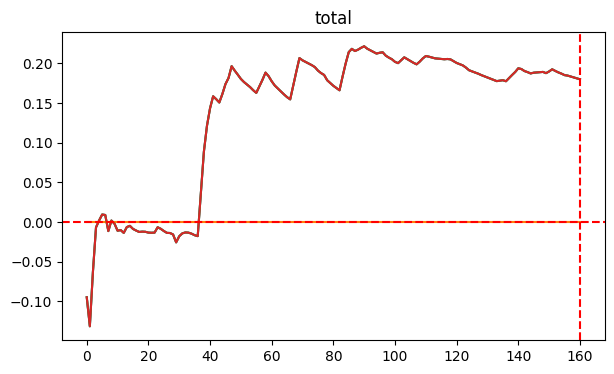

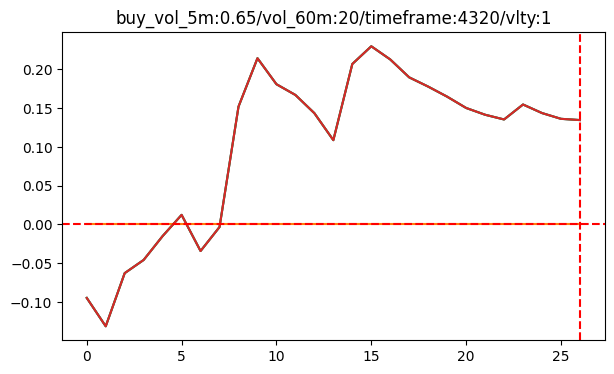

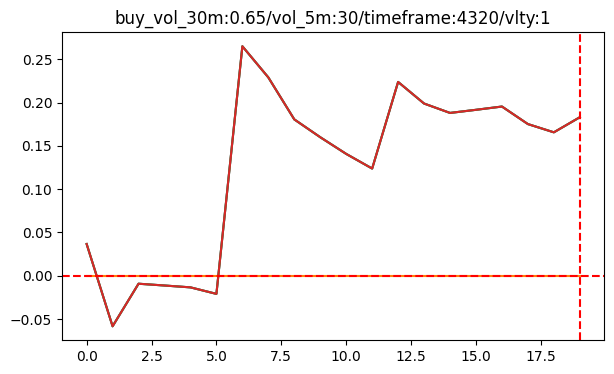

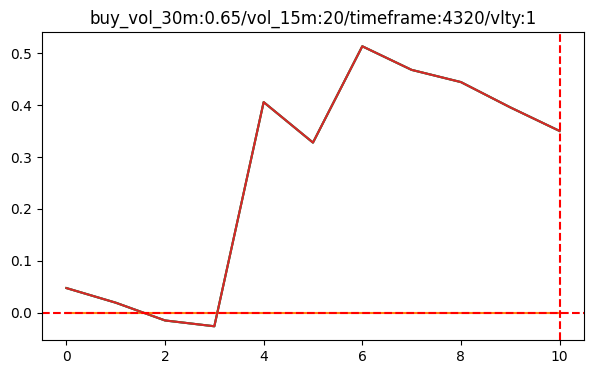

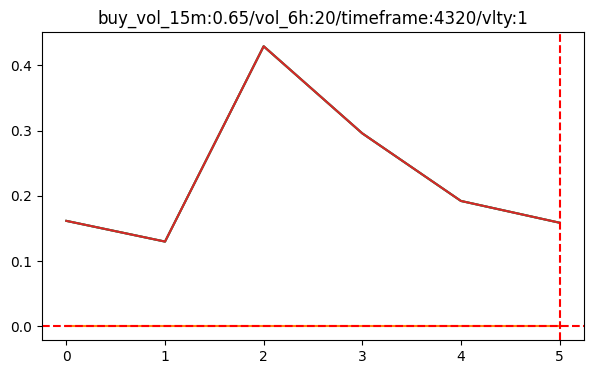

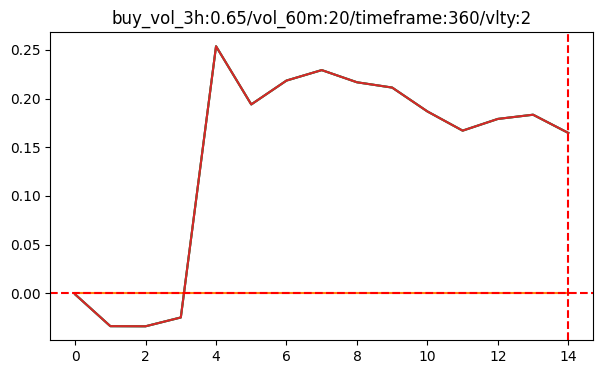

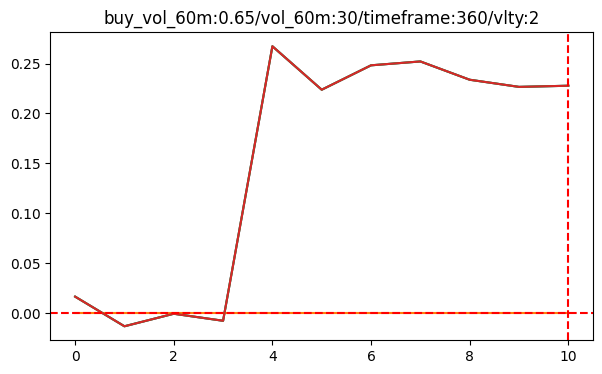

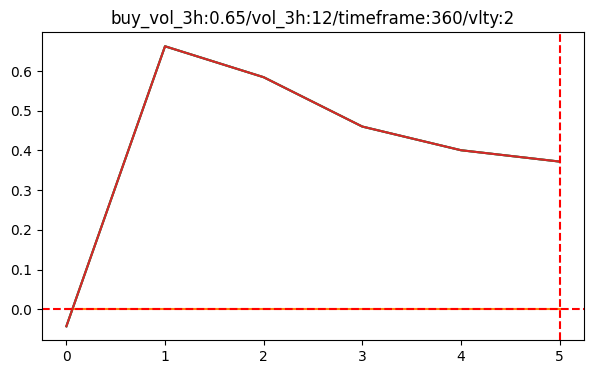

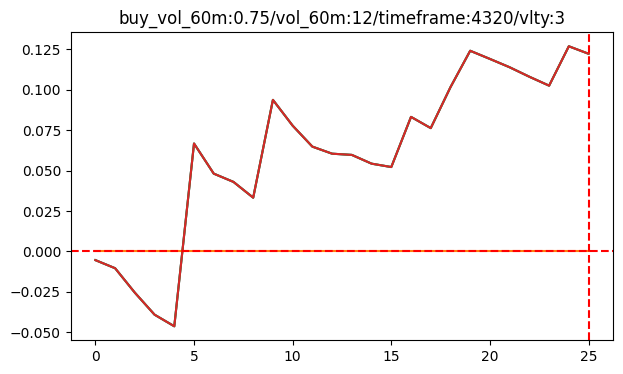

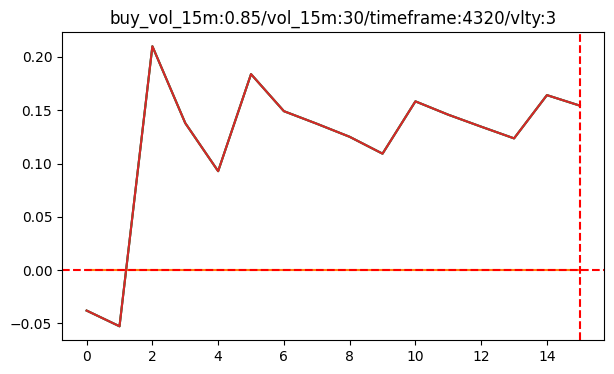

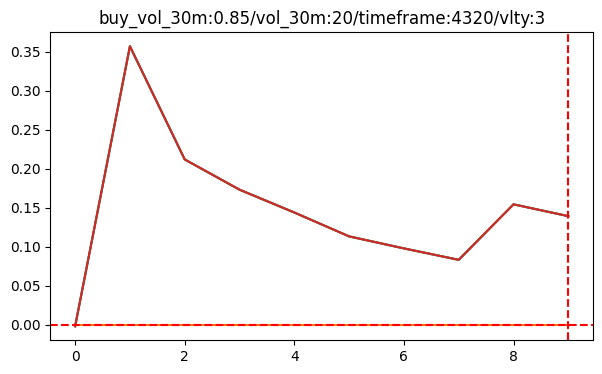

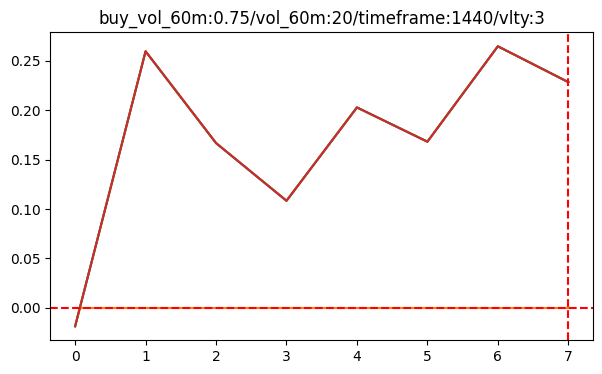

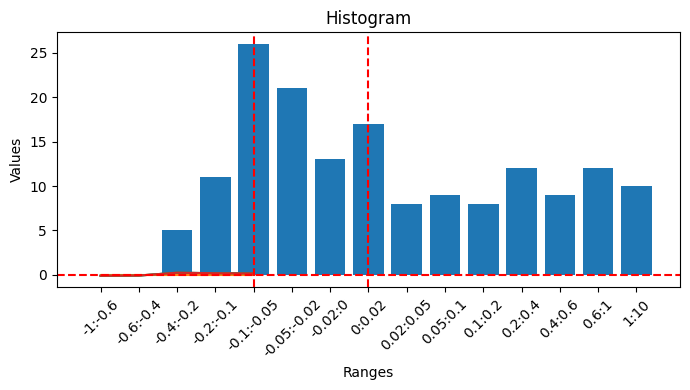

Positive events: 83
Negative events: 78
Biggest Drop: 56.04 at 2023-07-20T05:59:02.353163


,event,mean_series,mean_event,balance,coin
0,2023-05-12T16:49:01.675528,-0.094753,-0.094753,993.84,ARPAUSDT
1,2023-05-19T18:01:02.451051,-0.131351,-0.167949,982.92,AGIXUSDT
2,2023-05-24T05:59:02.689721,-0.062787,0.074341,987.75,ARPAUSDT
3,2023-05-24T09:36:02.030124,-0.006708,0.161530,998.25,ARPAUSDT
4,2023-06-02T21:49:02.680186,0.001953,0.036599,1000.63,TRXUSDT
5,2023-06-04T13:28:02.722975,0.009513,0.047310,1003.71,LUNCUSDT
6,2023-06-04T14:07:02.212359,0.008926,0.005406,1004.06,LUNCUSDT
7,2023-06-08T11:08:02.548602,-0.011382,-0.153542,994.08,STXUSDT
8,2023-06-10T05:26:02.453763,0.001910,0.108247,1001.12,ADAUSDT
9,2023-06-13T09:17:02.535238,-0.002071,-0.037903,998.66,BONDUSDT


In [4]:
from Functions import analyzeRiskManagementPerformance

riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-8-25-[25, 15, 10, 5]-5-998.json"
OPTIMIZED=True
df, biggest_drop, biggest_drop_date, positive_outcome, negative_outcome, PERFORMANCE_SCENARIOS = analyzeRiskManagementPerformance(riskmanagement_path, OPTIMIZED)
import pandas as pd
pd.set_option('display.max_rows', 1000)
print(f'Positive events: {positive_outcome}')
print(f'Negative events: {negative_outcome}')
print(f'Biggest Drop: {biggest_drop} at {biggest_drop_date}')

df

['buy_vol_5m:0.65/vol_60m:20/timeframe:4320/vlty:1', 'buy_vol_30m:0.65/vol_5m:30/timeframe:4320/vlty:1', 'buy_vol_30m:0.65/vol_15m:20/timeframe:4320/vlty:1', 'buy_vol_15m:0.65/vol_6h:20/timeframe:4320/vlty:1', 'buy_vol_3h:0.65/vol_60m:20/timeframe:360/vlty:2', 'buy_vol_60m:0.65/vol_60m:30/timeframe:360/vlty:2', 'buy_vol_3h:0.65/vol_3h:12/timeframe:360/vlty:2', 'buy_vol_60m:0.75/vol_60m:12/timeframe:4320/vlty:3', 'buy_vol_15m:0.85/vol_15m:30/timeframe:4320/vlty:3', 'buy_vol_30m:0.85/vol_30m:20/timeframe:4320/vlty:3', 'buy_vol_60m:0.75/vol_60m:20/timeframe:1440/vlty:3', 'buy_vol_24h:0.65/vol_6h:12/timeframe:1440/vlty:4']
KEY NOT PRESENT: buy_vol_15m:0.75/vol_30m:20/timeframe:360/vlty:2
KEY NOT PRESENT: buy_vol_30m:0.65/vol_3h:50/timeframe:1440/vlty:4


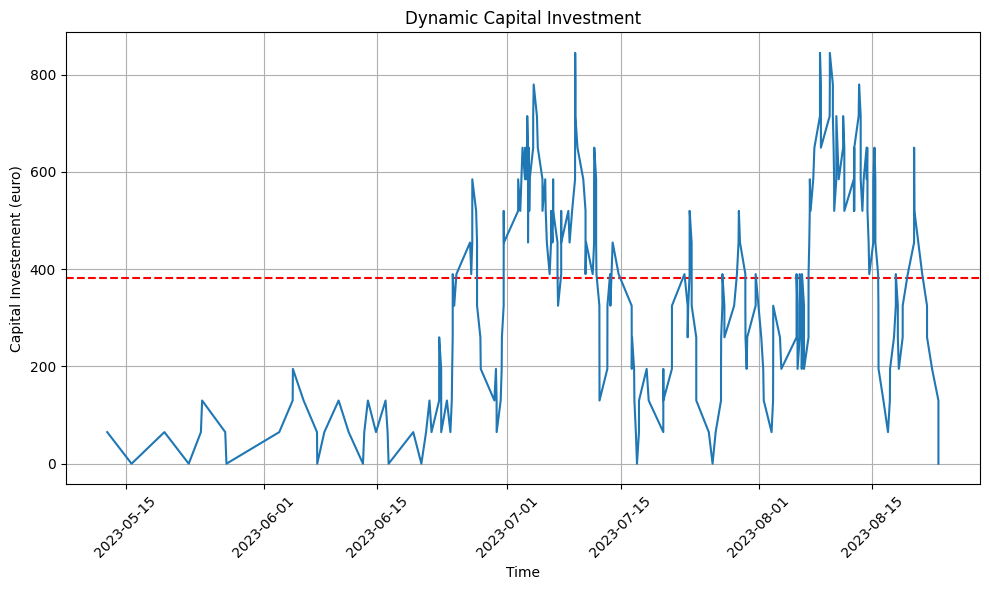

In [3]:
from Functions import check_invevestment_amount
riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-8-25-[25, 15, 10, 5]-5-998.json"
check_invevestment_amount(info, output, investment_amount=65, riskmanagement_path=riskmanagement_path)

In [2]:
PERFORMANCE_SCENARIOS

{'-1:-0.6': [[-1, -0.6], 0],
 '-0.6:-0.4': [[-0.6, -0.4], 0],
 '-0.4:-0.2': [[-0.4, -0.2], 3],
 '-0.2:-0.1': [[-0.2, -0.1], 7],
 '-0.1:-0.05': [[-0.1, -0.05], 16],
 '-0.05:-0.02': [[-0.05, -0.02], 27],
 '-0.02:0': [[-0.02, 0], 29],
 '0:0.02': [[0, 0.02], 15],
 '0.02:0.05': [[0.02, 0.05], 10],
 '0.05:0.1': [[0.05, 0.1], 4],
 '0.1:0.2': [[0.1, 0.2], 15],
 '0.2:0.4': [[0.2, 0.4], 24],
 '0.4:0.6': [[0.4, 0.6], 5],
 '0.6:1': [[0.6, 1], 5],
 '1:10': [[1, 10], 2]}